Screenshot without waveform saved as: screenshot_no_wave.png
Screenshot with waveform saved as: screenshot_with_wave.png
Extracted waveform data: [ 9.90909091 10.74545455 11.36969697 11.78181818 11.98181818 11.96969697
 11.63403263 10.96037296 10.3962704   9.84382284  9.37296037  9.05361305
  8.95571096  8.93706294  8.91608392  9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          9.          9.          9.          9.          9.
  9.          8.91608392  8.93706294  9.03962704  9.2004662   9.3962704
  9.6037296   9.7995338   9.96037296 10.06293706 10

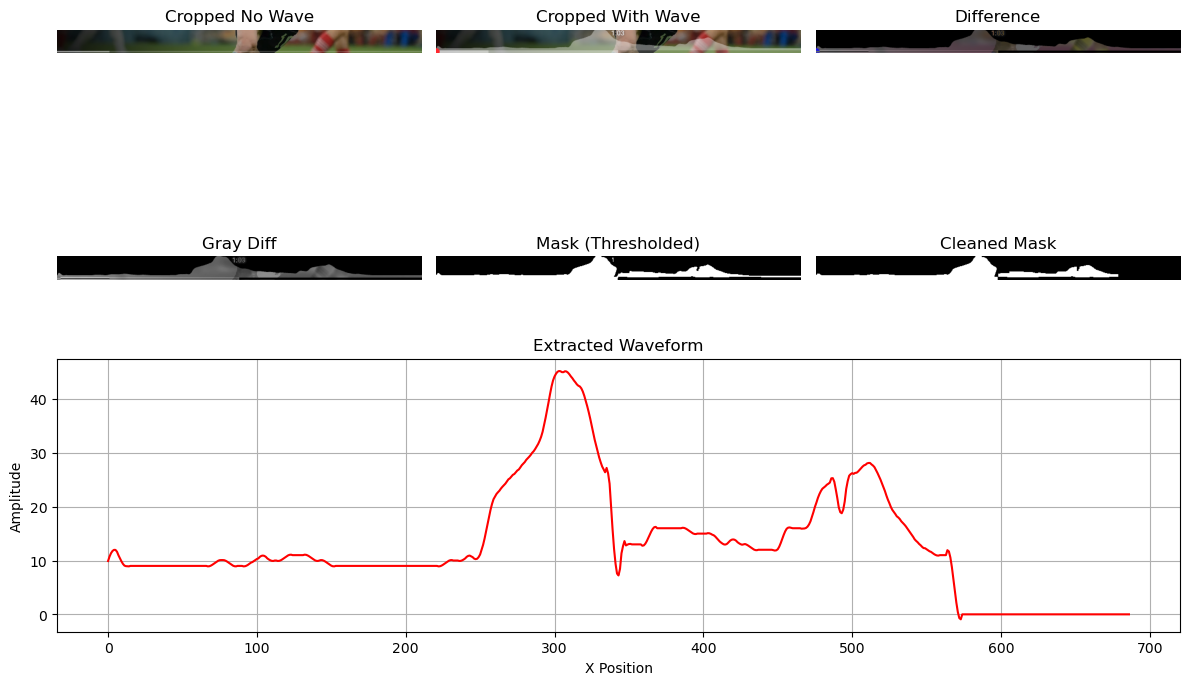

In [ ]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from scipy.signal import savgol_filter


# PART 1: Web Automation and Screenshot Capture

# Initialize WebDriver (ensure ChromeDriver is installed and in PATH)
driver = webdriver.Chrome()

# Load the YouTube video page
video_url = "https://www.youtube.com/watch?v=Rb6P2sdlJTE"  # video URL
driver.get(video_url)
time.sleep(5)  # Wait for the page to load fully

# Locate the progress bar
progress_bar = driver.find_element(By.CLASS_NAME, "ytp-progress-bar-container")

# Determine the bounding box for cropping the progress bar region
def get_progress_bar_bounds(progress_bar, offset_above=40):
    """
    Returns the bounding box (x1, y1, x2, y2) for the progress bar region,
    including an optional offset above to capture the waveform.
    """
    bar_location = progress_bar.location
    bar_size = progress_bar.size
    bar_x = bar_location['x']
    bar_y = bar_location['y']
    bar_width = bar_size['width']
    bar_height = bar_size['height']
    # Crop from (bar_y - offset_above) to (bar_y + bar_height)
    x1 = bar_x
    y1 = max(bar_y - offset_above, 0)
    x2 = bar_x + bar_width
    y2 = bar_y + bar_height
    return x1, y1, x2, y2

# Set the cropping offset (adjustable to capture waveform while minimizing UI elements)
offset_above = 40  # Adjust as needed (e.g., 20-50)
x1, y1, x2, y2 = get_progress_bar_bounds(progress_bar, offset_above=offset_above)

# Take screenshot WITHOUT waveform (do NOT hover)
screenshot_no_wave = "screenshot_no_wave.png"
driver.save_screenshot(screenshot_no_wave)
print("Screenshot without waveform saved as:", screenshot_no_wave)

# Take screenshot WITH waveform (hover over progress bar)
ActionChains(driver).move_to_element(progress_bar).perform()
time.sleep(2)  # Wait for the waveform overlay to appear
screenshot_with_wave = "screenshot_with_wave.png"
driver.save_screenshot(screenshot_with_wave)
print("Screenshot with waveform saved as:", screenshot_with_wave)

# Close the browser
driver.quit()


# PART 2: Image Processing and Waveform Extraction


# Load the screenshots
img_no_wave = cv2.imread(screenshot_no_wave)
img_with_wave = cv2.imread(screenshot_with_wave)

if img_no_wave is None or img_with_wave is None:
    raise ValueError("Could not read one of the screenshots. Check file paths.")

# Crop both screenshots to the same region
def crop_image(img, x1, y1, x2, y2):
    """
    Crops the image to the specified bounding box (x1, y1, x2, y2).
    Note: OpenCV uses [row:row_end, col:col_end] = [y:y2, x:x2].
    """
    return img[y1:y2, x1:x2]

cropped_no_wave = crop_image(img_no_wave, x1, y1, x2, y2)
cropped_with_wave = crop_image(img_with_wave, x1, y1, x2, y2)

# Compute image difference
diff = cv2.absdiff(cropped_with_wave, cropped_no_wave)

# Convert difference to grayscale
gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
gray_diff_blurred = cv2.GaussianBlur(gray_diff, (5, 5), 0)

# Threshold the blurred difference image (adjust threshold to reduce noise)
_, mask_diff = cv2.threshold(gray_diff_blurred, 50, 255, cv2.THRESH_BINARY)

# Morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask_diff, cv2.MORPH_OPEN, kernel)  # Remove small noise
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))  # Fill small gaps

# Extract waveform data from the cleaned mask
waveform_data = []
height = mask_clean.shape[0]
for x in range(mask_clean.shape[1]):
    column = mask_clean[:, x]
    y_positions = np.where(column > 0)[0]
    if len(y_positions) > 0:
        # Topmost white pixel (inverted y-axis)
        waveform_data.append(height - y_positions[0])
    else:
        waveform_data.append(0)

waveform_data = np.array(waveform_data)

# Post-process the waveform data using Savitzky-Golay filter for smoothing
smoothed_waveform = savgol_filter(waveform_data, window_length=11, polyorder=2)
waveform_data = smoothed_waveform

print("Extracted waveform data:", waveform_data)


# PART 3: Visualization

plt.figure(figsize=(12, 8))

# Top row: Cropped images
plt.subplot(3, 3, 1)
plt.title("Cropped No Wave")
plt.imshow(cv2.cvtColor(cropped_no_wave, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(3, 3, 2)
plt.title("Cropped With Wave")
plt.imshow(cv2.cvtColor(cropped_with_wave, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(3, 3, 3)
plt.title("Difference")
plt.imshow(diff, cmap='gray')
plt.axis('off')

# Middle row: Processed images
plt.subplot(3, 3, 4)
plt.title("Gray Diff")
plt.imshow(gray_diff, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title("Mask (Thresholded)")
plt.imshow(mask_diff, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.title("Cleaned Mask")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

# Bottom: Extracted waveform
plt.subplot(3, 1, 3)
plt.title("Extracted Waveform")
plt.plot(waveform_data, color='red')
plt.xlabel("X Position")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()